<a href="https://colab.research.google.com/github/jadercaro/Curso-Deep-Learning-20242/blob/main/U4_LAB_03_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 4.3 - Object detection

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False);

replicating local resources


In [102]:
from local.lib.rlxmoocapi import submit, session
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L04.03", varname="student");

logging in as jader.caro@udea.edu.co ... please wait

-------------
using course session 2021.deeplearning::udea.20242
success!! you are logged in
-------------


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
%matplotlib inline
from IPython.display import Image

## TASK 1: Create anchor boxes

observe how we download and extract the first 20K bounding-box annotations from the Open Images V6 dataset, out of the total 14M available. We are interested in the width and height of each box, which we must obtain by substracting the box coordinates, according to the description [here](https://storage.googleapis.com/openimages/web/download.html). Recall that the coordinates are $\in [0,1]$ as they are relative to the image size

In [4]:
!wget -nc https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv

--2024-10-13 18:42:39--  https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2258447590 (2.1G) [text/csv]
Saving to: ‘oidv6-train-annotations-bbox.csv’

oidv6-train-annotat 100%[===================>]   2.10G  39.7MB/s    in 56s     

2024-10-13 18:43:36 (38.4 MB/s) - ‘oidv6-train-annotations-bbox.csv’ saved [2258447590/2258447590]



In [5]:
!wc oidv6-train-annotations-bbox.csv
!head -5 oidv6-train-annotations-bbox.csv

  14610230   14610230 2258447590 oidv6-train-annotations-bbox.csv
ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0,0.148438,0.012500,0.059375,0.195312,0.148438,0.357812,0.587500,0.325000
000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0,0.025000,0.248438,0.276563,0.214062,0.914062,0.714063,0.782813,0.948438
000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0,0.243750,0.151562,0.310937,0.262500,0.198437,0.434375,0.507812,0.590625
000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0,0.315625,0.429688,0.256250,0.423438,0.651563,0.921875,0.826562,0.925000


The `X` numpy array now contains the width and height of bounding boxes

In [6]:
!head -20001 oidv6-train-annotations-bbox.csv > oidv6-train-annotations-bbox-20k.csv
d = pd.read_csv('oidv6-train-annotations-bbox-20k.csv')
w = (d.XMax-d.XMin).values
h = (d.YMax-d.YMin).values
X = np.r_[[w,h]].T
X[:6]

array([[0.182812, 0.439062],
       [0.251563, 0.234375],
       [0.159375, 0.392188],
       [0.173438, 0.273437],
       [0.089063, 0.15    ],
       [0.048438, 0.067187]])

we can paint a sample of them

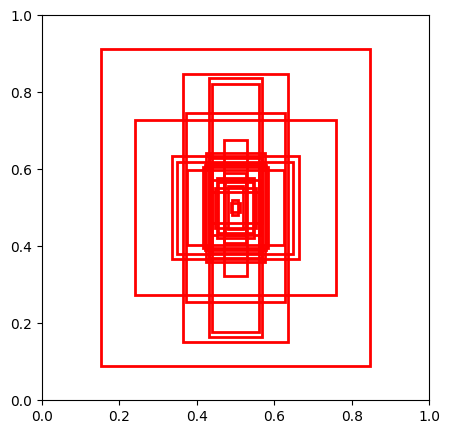

In [7]:

from matplotlib.patches import Rectangle
plt.figure(figsize=(5,5));
ax = plt.subplot(111)

for w,h in np.random.permutation(X)[:25]:
    ax.add_patch(Rectangle((0.5-w/2,0.5-h/2),w,h, linewidth=2,edgecolor='r',facecolor='none'))


Complete the following function such that it creates `n` anchor boxes from the bounding boxes in `X` using [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) with `n_clusters` set to the number of anchor boxes desired. After fitting KMeans, return  cluster centers. Use the `random_state` passed as argument in KMeans.

In [8]:
def get_anchor_boxes(X, n, random_state=0):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n, random_state=random_state)
    kmeans.fit(X)
    km = kmeans.cluster_centers_
    return km

you can visualize your anchor boxes. You should get something similar to this

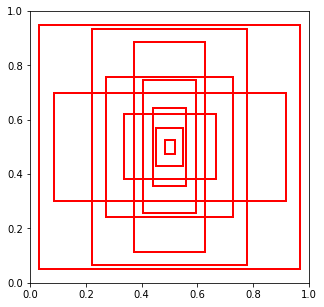

In [9]:
Image("local/imgs/anchor_boxes.png", width=300)

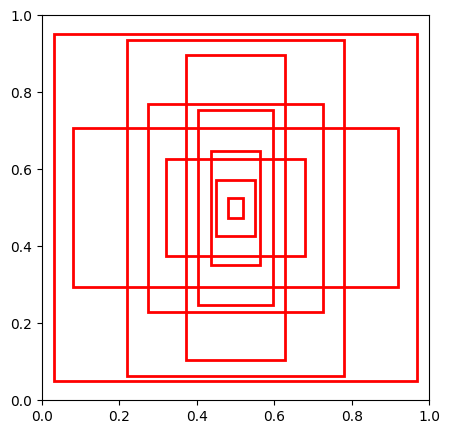

In [10]:
from matplotlib.patches import Rectangle
anchors = get_anchor_boxes(X, n=10, random_state=0)
plt.figure(figsize=(5,5));
ax = plt.subplot(111)

for w,h in anchors:
    ax.add_patch(Rectangle((0.5-w/2,0.5-h/2),w,h, linewidth=2,edgecolor='r',facecolor='none'))

**Registra tu solución en linea**

In [11]:
student.submit_task(namespace=globals(), task_id='T1');

## TASK 2: Get closest anchor

assume we have these anchor boxes, sorted by size

In [12]:
kc = np.array([0.03612632, 0.05025544, 0.0982887 , 0.1392435 , 0.11913009,
       0.28577818, 0.32945173, 0.23846835, 0.18874274, 0.48914381,
       0.25347843, 0.77500826, 0.45506799, 0.51589807, 0.83168319,
       0.39802428, 0.5539543 , 0.86824085, 0.93553054, 0.89561131]).reshape(10,2)
kc = kc[np.argsort(np.product(kc, axis=1))]
anchors = pd.DataFrame(kc, columns=['w', 'h'])
anchors

,w,h
0,0.036126,0.050255
1,0.098289,0.139243
2,0.119130,0.285778
3,0.329452,0.238468
4,0.188743,0.489144
5,0.253478,0.775008
6,0.455068,0.515898
7,0.831683,0.398024
8,0.553954,0.868241
9,0.935531,0.895611


Complete the following function so that, given a bounding box `XMin, XMax, YMin, YMax` and a dataframe with anchors such as `kc` above
returns the index of the most similar anchor to the bouding box.

Recall that all values $\in [0,1]$

Given two boxes (bounding box and anchor) with widths and heights $w_0, h_0$ and $w_1, h_1$, we define their similarity measure as:

$$|w_0-w_1| + |h_0-h_1|$$

Your return value must be an integer between 0 and 9

In [13]:
def get_closest_anchor_box(XMin, XMax, YMin, YMax, anchors):
    w = XMax - XMin
    h = YMax - YMin
    return np.argmin(np.abs(anchors.w - w) + np.abs(anchors.h - h))

you can visualize random annotations and their corresponding anchor boxes according to your function below. Your should see things like this one

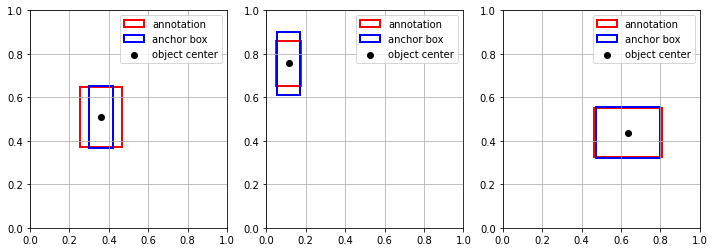

In [14]:
Image("local/imgs/annotations-anchors.png", width=600)

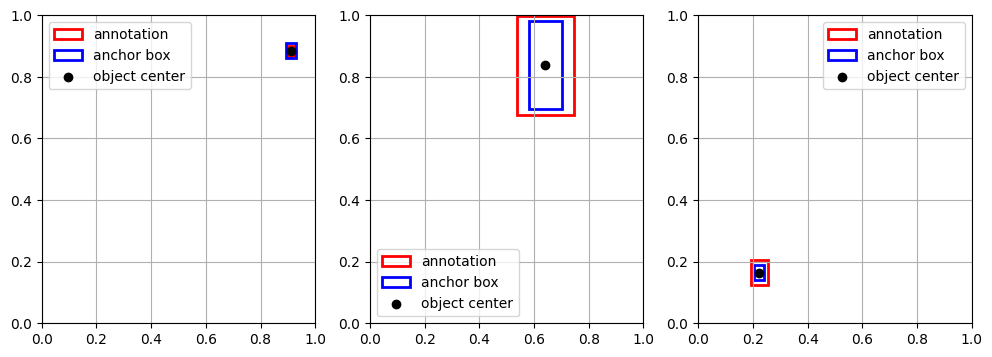

In [15]:
plt.figure(figsize=(12,4));
for i in range(3):
    b = d.iloc[np.random.randint(len(d))]
    bx, by = b.XMin + (b.XMax-b.XMin)/2, b.YMin + (b.YMax-b.YMin)/2
    bw, bh = b.XMax - b.XMin, b.YMax - b.YMin
    pw, ph = anchors.values[get_closest_anchor_box(b.XMin, b.XMax, b.YMin, b.YMax, anchors)]

    ax = plt.subplot(1,3,i+1)
    ax.add_patch(Rectangle((bx-bw/2,by-bh/2),bw,bh, linewidth=2,edgecolor='r',facecolor='none', label="annotation"))
    ax.add_patch(Rectangle((bx-pw/2,by-ph/2),pw,ph, linewidth=2,edgecolor='b',facecolor='none', label="anchor box"))
    plt.scatter(bx, by, color="black", label="object center")
    plt.grid(); plt.legend()
    plt.xlim(0,1); plt.ylim(0,1);


**Registra tu solución en linea**

In [16]:
student.submit_task(namespace=globals(), task_id='T2');

## TASK 3: Compute desired model bounding box predictions

Understand the schema of YOLO coordinates below

- $b_w$, $b_h$ are the width and height of the annotation we want the model to predict
- $b_x$, $b_y$ are $x$ and $y$ coordinate of the annotation we want the model to predict
- $p_w$, $p_h$ are the width and height of its closest anchor box
- $c_x$, $c_y$ are the $x$ and $y$ coordinates of the **TOP LEFT** corner of the image cell responsible for detecting the annotation

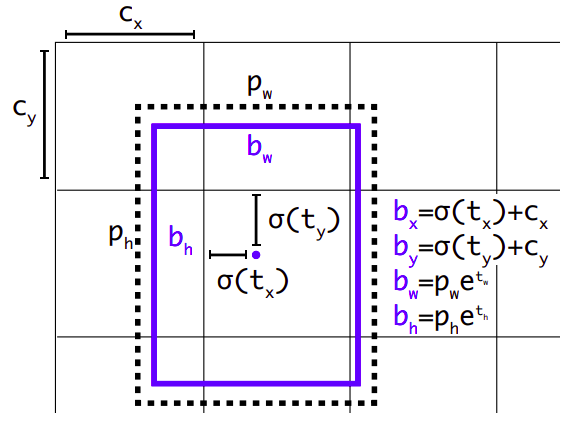

In [ ]:
Image("local/imgs/yolo_predictions.png", width=400)

Complete the following function such that, when given $b_x$, $b_y$, $b_w$, $b_h$, $p_w$, $p_h$, $n_w$, $n_h$ returns:

- $n_x \in \{0,1,..,n_x-1\}$, $n_y \in  \{0,1,..,n_y-1\}$: the cell number in which the annotation center ($b_x$, $b_y$) falls in.
- $t_x$, $t_y$, $t_w$, $t_h$: the desired model predictions according to the figure above

$n_w$ and $n_h$ specify the grid size in terms of number of cells wide and number of cells high.




In [117]:
def get_model_target_predictions(bx, by, bw, bh, pw, ph, nw, nh):
  nx = np.floor(bx*nw).astype(int)
  ny = np.floor(by*nh).astype(int)
  tx = np.log(bx * nw - nx)
  ty = np.log(by * nh - ny)
  tw = np.log(bw/pw)
  th = np.log(bh/ph)
  return nx, ny, tx, ty, tw, th


In [131]:
def get_model_target_predictions(bx, by, bw, bh, pw, ph, nw, nh):
  nx = np.floor(bx*nw).astype(int)
  ny = np.floor(by*nh).astype(int)
  tx = bx * nw - nx
  ty = by * nh - ny
  tx = np.log(tx)
  ty = np.log(ty)
  tw = np.log(bw/pw)
  th = np.log(bh/ph)
  return nx, ny, tx, ty, tw, th

2.8699999999999997

check your code. For the following values, you should get

- $n_x$, $n_y$ = `1, 4`
- $t_x$, $t_y$ = `-2.63, -3.89`
- $t_w$, $t_h$ = `-0.92, 0.14`

Make sure the values make sense (why are they positive or negative)

In [132]:
nw, nh = 7, 5
bx, by = 0.21, 0.82
bw, bh = 0.02, 0.15
pw, ph = 0.05, 0.13


get_model_target_predictions(bx, by, bw, bh, pw, ph, nw, nh)

(1,
 4,
 -0.7550225842780328,
 -2.3025850929940495,
 -0.9162907318741551,
 0.14310084364067324)

try with other cases generated randomly

In [100]:
nw, nh = np.random.randint(6, size=2)+5
bx, by = np.round(np.random.random(size=2)*.4+.3,3)
bw, bh = np.round(np.random.random(size=2)*.25,3)
pw, ph = np.round(np.r_[bw, bh] * (1+np.random.random(size=2)*0.3-0.15),3)

print ("inputs", nw, nh, bx, by, bw, bh, pw, ph)
get_model_target_predictions(bx, by, bw, bh, pw, ph, nw, nh)

inputs 6 7 0.485 0.459 0.186 0.239 0.168 0.206


(2, 3, 29.59, 4.024864077669906, 0.10178269430994218, 0.1485873831419295)

**Registra tu solución en linea**

In [127]:
student.submit_task(namespace=globals(), task_id='T3');